<a href="https://colab.research.google.com/github/minh071289/MachineLearning/blob/main/copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
Your task is to create a neural network to classify images in the cifar100 dataset.
- You have to write the code from scratch, train the model and test the accuracy on the test set.
- You are not allowed to use pretrained models to do this task.
- You have to submit the .ipynb files with the execution result.

# Grading criteria
- You are graded on the test set accuracy:
  - Test accuracy = 0.50, Grade = 6
  - Test accuracy = 0.55, Grade = 7
  - Test accuracy = 0.60, Grade = 8
  - Test accuracy = 0.65, Grade = 9
  - Test accuracy = 0.70, Grade = 10
- Plagiarism will automatically results in 0 mark.


In [12]:
# DO NOT MODIFY THIS CODE
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from tqdm.auto import tqdm, trange

In [13]:
# You are free to use any other kind of transforms here
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409],
                         std=[0.2673, 0.2564, 0.2762])
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409],
                         std=[0.2673, 0.2564, 0.2762])
])

cifar100_train = datasets.CIFAR100(root='./data',
                                       train=True,
                                       download=True,
                                       transform=transform_train)

cifar100_test = datasets.CIFAR100('./data',
                              train=False,
                              download=True,
                              transform=transform_test)

In [3]:
print(len(cifar100_train))
print(len(cifar100_test))

50000
10000


In [15]:
# DO NOT MODIFY THIS CODE
def evaluate(net: nn.Module,
             data) -> float:
  """
  Evaluates the neural network on the given data.
  @param net: the neural network to evaluate
  @param data: the data to evaluate on
  @return: the accuracy of the neural network on the given data
  """
  data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=100,
                                            shuffle=False)
  correct = 0
  total = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net.to(device)
  net.eval()
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      pred_target = net(inputs).argmax(dim=1)
      correct += (pred_target == targets).sum().item()
      total += targets.size(0)

  return correct / total

In [26]:
import math

class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super().__init__()
        inter_planes = 4 * growth_rate
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes, inter_planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(inter_planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_planes, growth_rate, kernel_size=3, padding=1, bias=False),
        )

    def forward(self, x):
        out = self.block(x)
        return torch.cat([x, out], dim=1)

class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.transition(x)

class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10, dropout_rate=0.2):
        super().__init__()
        self.growth_rate = growth_rate
        num_planes = 2 * growth_rate

        self.init_conv = nn.Sequential(
            nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_planes),
            nn.ReLU(inplace=True)
        )

        self.features = nn.Sequential()
        for i in range(len(nblocks)):
            dense = self._make_dense_layers(block, num_planes, nblocks[i])
            self.features.add_module(f'denseblock{i+1}', dense)
            num_planes += nblocks[i] * growth_rate

            if i != len(nblocks) - 1:
                out_planes = int(math.floor(num_planes * reduction))
                trans = Transition(num_planes, out_planes)
                self.features.add_module(f'transition{i+1}', trans)
                num_planes = out_planes

        self.final_bn = nn.BatchNorm2d(num_planes)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for _ in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.features(out)
        out = F.relu(self.final_bn(out), inplace=True)
        out = F.adaptive_avg_pool2d(out, 1)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        return self.classifier(out)

def densenet_cifar(num_classes=100):
    return DenseNet(Bottleneck, [16, 16, 16], growth_rate=24, num_classes=num_classes)


In [27]:
def train(train_data, net, **kwargs) -> Tuple[nn.Module, list[float], list[float]]:
    train_losses, train_accuracies = [], []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.train()

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=kwargs['batch_size'], shuffle=True)

    optimizer = opt.AdamW(net.parameters(), lr=kwargs['lr'], weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kwargs['epochs'])
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    for epoch in trange(kwargs['epochs']):
        epoch_loss = 0
        for inputs, targets in tqdm(train_loader, leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = net(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()

        avg_loss = epoch_loss / len(train_loader)
        train_acc = evaluate(net, train_data)
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Train Acc={train_acc:.4f}")

    return net, train_losses, train_accuracies

In [28]:
net = densenet_cifar()
lr = 0.001
batch_size = 128
epochs = 100

net, train_losses, train_accuracies = train(train_data=cifar100_train,
                                            net=net,
                                            lr=lr,
                                            batch_size=batch_size,
                                            epochs=epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1: Loss=4.0696, Train Acc=0.1500


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2: Loss=3.9104, Train Acc=0.1830


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3: Loss=3.5004, Train Acc=0.2595


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4: Loss=3.2148, Train Acc=0.3197


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5: Loss=2.9933, Train Acc=0.3726


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6: Loss=2.7994, Train Acc=0.4266


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7: Loss=2.6576, Train Acc=0.4477


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8: Loss=2.5368, Train Acc=0.4977


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9: Loss=2.4368, Train Acc=0.5310


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10: Loss=2.3424, Train Acc=0.5585


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11: Loss=2.2612, Train Acc=0.5689


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12: Loss=2.1887, Train Acc=0.6037


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13: Loss=2.1189, Train Acc=0.6266


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14: Loss=2.0549, Train Acc=0.6353


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15: Loss=2.0015, Train Acc=0.6497


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16: Loss=1.9523, Train Acc=0.6608


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17: Loss=1.9000, Train Acc=0.6873


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18: Loss=1.8586, Train Acc=0.7042


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19: Loss=1.8090, Train Acc=0.7191


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20: Loss=1.7685, Train Acc=0.7283


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21: Loss=1.7308, Train Acc=0.7455


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22: Loss=1.6937, Train Acc=0.7533


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23: Loss=1.6546, Train Acc=0.7774


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24: Loss=1.6169, Train Acc=0.7687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25: Loss=1.5951, Train Acc=0.7832


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26: Loss=1.5673, Train Acc=0.8037


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27: Loss=1.5312, Train Acc=0.8195


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28: Loss=1.5039, Train Acc=0.8109


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29: Loss=1.4790, Train Acc=0.8372


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30: Loss=1.4496, Train Acc=0.8399


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31: Loss=1.4275, Train Acc=0.8578


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32: Loss=1.3997, Train Acc=0.8536


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33: Loss=1.3833, Train Acc=0.8643


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34: Loss=1.3581, Train Acc=0.8784


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35: Loss=1.3408, Train Acc=0.8772


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36: Loss=1.3260, Train Acc=0.8888


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37: Loss=1.3110, Train Acc=0.8927


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38: Loss=1.2853, Train Acc=0.8986


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39: Loss=1.2740, Train Acc=0.9069


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40: Loss=1.2611, Train Acc=0.9104


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41: Loss=1.2540, Train Acc=0.9164


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42: Loss=1.2411, Train Acc=0.9190


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43: Loss=1.2241, Train Acc=0.9198


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44: Loss=1.2102, Train Acc=0.9241


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45: Loss=1.2043, Train Acc=0.9259


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46: Loss=1.1855, Train Acc=0.9312


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47: Loss=1.1753, Train Acc=0.9305


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48: Loss=1.1637, Train Acc=0.9400


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49: Loss=1.1554, Train Acc=0.9398


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50: Loss=1.1448, Train Acc=0.9419


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 51: Loss=1.1354, Train Acc=0.9454


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 52: Loss=1.1317, Train Acc=0.9479


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 53: Loss=1.1197, Train Acc=0.9501


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 54: Loss=1.1117, Train Acc=0.9519


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 55: Loss=1.1058, Train Acc=0.9508


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 56: Loss=1.1003, Train Acc=0.9527


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 57: Loss=1.0924, Train Acc=0.9570


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 58: Loss=1.0846, Train Acc=0.9581


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 59: Loss=1.0760, Train Acc=0.9577


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 60: Loss=1.0788, Train Acc=0.9600


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 61: Loss=1.0666, Train Acc=0.9612


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 62: Loss=1.0657, Train Acc=0.9612


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 63: Loss=1.0585, Train Acc=0.9620


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 64: Loss=1.0505, Train Acc=0.9643


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 65: Loss=1.0501, Train Acc=0.9666


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 66: Loss=1.0455, Train Acc=0.9686


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 67: Loss=1.0382, Train Acc=0.9684


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 68: Loss=1.0328, Train Acc=0.9682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 69: Loss=1.0292, Train Acc=0.9689


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 70: Loss=1.0238, Train Acc=0.9684


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 71: Loss=1.0231, Train Acc=0.9697


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 72: Loss=1.0180, Train Acc=0.9709


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 73: Loss=1.0138, Train Acc=0.9696


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 74: Loss=1.0121, Train Acc=0.9714


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 75: Loss=1.0070, Train Acc=0.9715


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 76: Loss=1.0058, Train Acc=0.9724


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 77: Loss=0.9997, Train Acc=0.9736


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 78: Loss=0.9976, Train Acc=0.9739


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 79: Loss=0.9948, Train Acc=0.9745


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 80: Loss=0.9922, Train Acc=0.9747


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 81: Loss=0.9914, Train Acc=0.9741


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 82: Loss=0.9923, Train Acc=0.9742


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 83: Loss=0.9844, Train Acc=0.9751


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 84: Loss=0.9862, Train Acc=0.9752


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 85: Loss=0.9862, Train Acc=0.9760


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 86: Loss=0.9847, Train Acc=0.9758


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 87: Loss=0.9787, Train Acc=0.9770


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 88: Loss=0.9801, Train Acc=0.9752


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 89: Loss=0.9773, Train Acc=0.9772


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 90: Loss=0.9769, Train Acc=0.9765


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 91: Loss=0.9748, Train Acc=0.9779


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 92: Loss=0.9736, Train Acc=0.9780


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 93: Loss=0.9739, Train Acc=0.9764


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 94: Loss=0.9705, Train Acc=0.9778


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 95: Loss=0.9736, Train Acc=0.9786


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 96: Loss=0.9728, Train Acc=0.9771


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 97: Loss=0.9716, Train Acc=0.9767


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 98: Loss=0.9696, Train Acc=0.9773


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 99: Loss=0.9698, Train Acc=0.9777


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 100: Loss=0.9727, Train Acc=0.9770


In [29]:
# DO NOT MODIFY THIS CODE
test_accuracy = evaluate(net, cifar100_test)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.6736


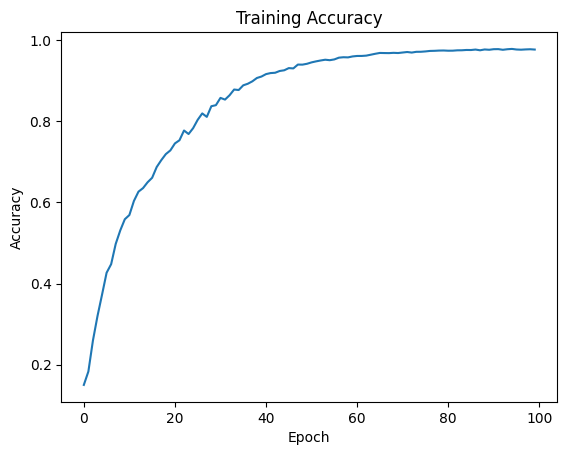

In [30]:
# DO NOT MODIFY THIS CODE
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

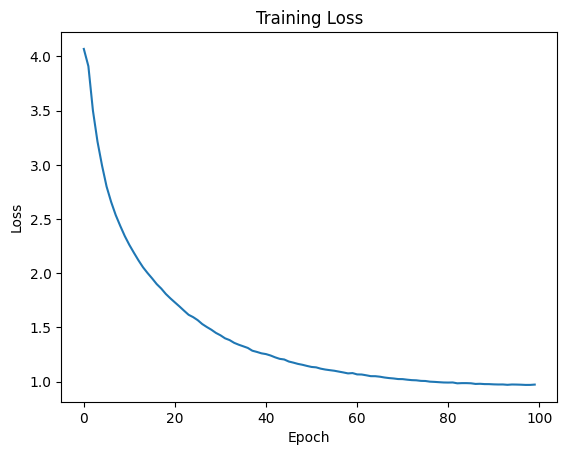

In [31]:
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()